In [1]:
import cv2
import torch
import random
import csv
import time
import copy

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
class R_net_Dataset(Dataset):
    def __init__(self, path, transform=None):
        with open(path, 'r') as f:
            self.lines = f.readlines()
        self.transform = transform
        
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        line = self.lines[idx].strip().split()

        img_path, label, offset = line[0], line[1], line[2:6]
        
        img = Image.open(img_path).convert('RGB')
        label = int(label)
        offset = np.array([float(x) for x in offset])
        
        sample = {'image': img, 'label': label, 'offset': offset}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [3]:
class ToTensor:
    def __call__(self, sample):
        image, label, offset = sample.values()
        
        image = transforms.ToTensor()(image)
        label = torch.from_numpy(np.array(label)).float()
        offset = torch.from_numpy(offset).float()
        
        return {'image': image, 'label': label, 'offset': offset}

In [4]:
class Random_Filp:
    def __call__(self, sample):
        image, label, offset = sample.values()

        pred = random.uniform(0, 1)
        if pred > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            offset[0], offset[2] = -offset[2], -offset[0]
            
        return {'image': image, 'label': label, 'offset': offset}

In [5]:
path = './anno_store/imglist_anno_24.txt'
trfm = transforms.Compose([Random_Filp()])

img_show = R_net_Dataset(path, trfm)

[23091, 28648, 27130, 20010, 13093]
[-1, 1, 1, -1, -1]
[array([ 0.09,  0.  , -0.22, -0.09]), array([ 0.08, -0.12,  0.04,  0.16]), array([-0.05,  0.05, -0.2 , -0.1 ]), array([ 0.05,  0.1 , -0.24, -0.07]), array([ 0.15,  0.15, -0.3 , -0.1 ])]


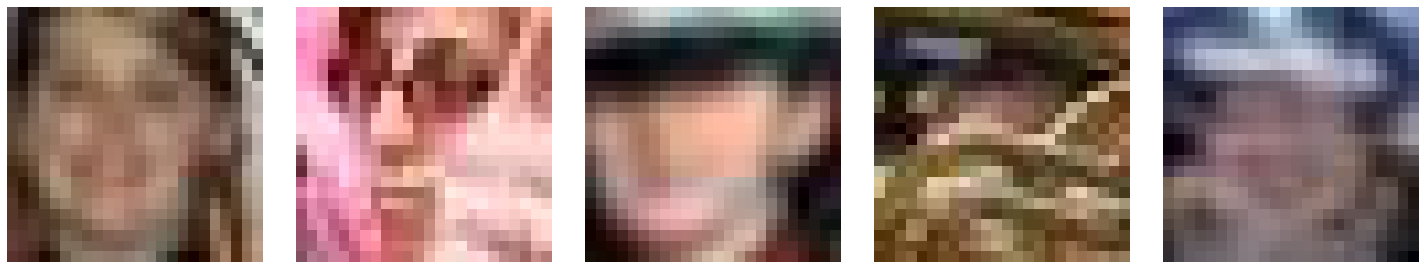

In [9]:
def my_show(data, nums):
    fig = plt.figure(figsize=(20, 5))
    lst = []
    labels = []
    offsets = []
    
    for i in range(nums):
        ax = plt.subplot(1, nums, i + 1)
        plt.tight_layout()
        
        n = random.randint(0, len(data))
        img, label, offset = data[n].values()
        
        lst.append(n)
        labels.append(label)
        offsets.append(offset)
        
        ax.imshow(np.array(img))
        ax.axis('off')
    print(lst)
    print(labels)
    print(offsets)
    
my_show(img_show, 5)


In [10]:
class RNet(nn.Module):

    def __init__(self):
        super(RNet, self).__init__()

        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1),  
            nn.PReLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2),  
            nn.Conv2d(28, 48, kernel_size=3, stride=1),  
            nn.PReLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2),  
            nn.Conv2d(48, 64, kernel_size=2, stride=1),  
            nn.PReLU()  
        )
        self.conv4 = nn.Linear(64*2*2, 128) 
        self.prelu4 = nn.PReLU()  

        self.conv5_1 = nn.Linear(128, 1)

        self.conv5_2 = nn.Linear(128, 4)


    def forward(self, x):

        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)

        label = torch.sigmoid(self.conv5_1(x))
        offset = self.conv5_2(x)
        
        return label, offset


In [11]:
def train_rnet(model_path, epoch, data_path, trfm, batch_size ,lr):

    
    dataset = R_net_Dataset(data_path, trfm)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    rnet = RNet()
#     weight = torch.FloatTensor([1, 4])
    criterion_cls = nn.BCELoss()
    criterion_box = nn.MSELoss()
    optimizer = optim.Adam(rnet.parameters(), lr=lr)
    
    since = time.time()
    best_model_wts = copy.deepcopy(rnet.state_dict())
    best_valid_loss = float('inf')
    
    t = 0
    
    for epoch_idx in range(epoch):
        rnet.train()
        epoch_time = time.time()
        loss_label_totle = 0.0
        loss_offset_totle = 0.0
        acc_positive = 0.0
        acc_negative = 0.0
        times = 0
        
        for batch_idx, batch in enumerate(train_dataloader):
            image, label, offset = batch.values()
            if label.size(0) < batch_size:
                continue
            
            p_label, p_offset = rnet(image)
            p_offset = torch.squeeze(p_offset)
            p_label = torch.squeeze(p_label)

            gt_label = label[label != -1]
            pre_label = p_label[label != -1]



            gt_offset = offset[label != 0]
            pre_offset = p_offset[label != 0]

            loss_cls = criterion_cls(pre_label, gt_label)
            loss_box = criterion_box(pre_offset, gt_offset)
            loss = loss_cls + 0.5 * loss_box
            
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 统计
#             _, pred = torch.max(pre_label, 1)
            pred = torch.ge(pre_label, 0.6).float()
            
            acc_positive += (gt_label[gt_label == 1] == pred[gt_label == 1]).sum().item() / (gt_label[gt_label == 1].size(0) + 0.001)
            acc_negative += (gt_label[gt_label == 0] == pred[gt_label == 0]).sum().item() / (gt_label[gt_label == 0].size(0) + 0.001)
            
            loss_label_totle += loss_cls.item()
            loss_offset_totle += (loss_box * 0.5).item()
            times += 1
        
        loss_label_totle /= times
        loss_offset_totle /= times
        loss_totle = loss_label_totle + loss_offset_totle
        acc_positive /= times
        acc_negative /= times
        t = time.time() - epoch_time
        
        if epoch_idx % 1 == 0:
            print('Epoch {} spend: {:.0f}m {:.0f}s'.format(epoch_idx, t // 60, t % 60))
            print('Valid: loss_totle: {:.4f} loss_label: {:.4f} loss_offset: {:.4f}'.format(loss_totle, loss_label_totle, loss_offset_totle))
            print('Label: acc_positive: {:.4f}, acc_negative: {:.4f}'.format(acc_positive, acc_negative))
            print('-' * 20)
            
        if loss_totle < best_valid_loss:
            best_model_wts = copy.deepcopy(rnet.state_dict())
            best_valid_loss = loss_totle
    
    rnet.load_state_dict(best_model_wts)
    time_elapesd = time.time() - since
    torch.save(rnet.state_dict(), model_path)
    
    print('=' * 50)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapesd // 60, time_elapesd % 60))
    print('Best val loss: {:4f}'.format(best_valid_loss))


In [12]:
model_path = './model_store/rnet.pkl'
data_path = './anno_store/imglist_anno_24.txt'
trfm = transforms.Compose([Random_Filp(), ToTensor()])
batch_size = 128
lr = 0.003
epoch = 20

In [13]:
train_rnet(model_path, epoch, data_path, trfm, batch_size ,lr)

Epoch 0 spend: 0m 26s
Valid: loss_totle: 0.4406 loss_label: 0.4217 loss_offset: 0.0190
Label: acc_positive: 0.0022, acc_negative: 0.9995
--------------------
Epoch 1 spend: 0m 24s
Valid: loss_totle: 0.3717 loss_label: 0.3557 loss_offset: 0.0159
Label: acc_positive: 0.1143, acc_negative: 0.9928
--------------------
Epoch 2 spend: 0m 25s
Valid: loss_totle: 0.3117 loss_label: 0.2966 loss_offset: 0.0151
Label: acc_positive: 0.3395, acc_negative: 0.9843
--------------------
Epoch 3 spend: 0m 26s
Valid: loss_totle: 0.2867 loss_label: 0.2721 loss_offset: 0.0145
Label: acc_positive: 0.4180, acc_negative: 0.9830
--------------------
Epoch 4 spend: 0m 26s
Valid: loss_totle: 0.2611 loss_label: 0.2470 loss_offset: 0.0141
Label: acc_positive: 0.4968, acc_negative: 0.9844
--------------------
Epoch 5 spend: 0m 26s
Valid: loss_totle: 0.2474 loss_label: 0.2335 loss_offset: 0.0139
Label: acc_positive: 0.5289, acc_negative: 0.9843
--------------------
Epoch 6 spend: 0m 25s
Valid: loss_totle: 0.2344 loss